In [180]:
# pip install imblearn

# Filtro automatizado de SPAM en SMS

In [182]:
# Librerias

import numpy as np # tratamiento de arreglos
import pandas as pd # tratamiento y carga de dataframes

import matplotlib.pyplot as plt # Graficos y matriz de graficos
import seaborn as sns # Graficar las distribuciones

import nltk # Construir modelos con cadenas

from nltk import word_tokenize # tokenizacion 
from nltk import word_tokenize # obtiene las palabras mas populares
from nltk import FreqDist # diccionario de frecuencia de tokens
from nltk.stem import SnowballStemmer # encontrar raices de cadenas

from wordcloud import WordCloud # grafico de frecuencia de palabras

from sklearn.feature_extraction.text import TfidfVectorizer # vectorizacion de las cadenas

import warnings # para ignorar las advertencias innecesarias de pandas

from sklearn.model_selection import train_test_split # paraticion de la data

from imblearn.under_sampling import RandomUnderSampler # submuestreo
from imblearn.over_sampling import RandomOverSampler # sobremuestreo

In [125]:
warnings.filterwarnings('ignore')

### Funciones

In [43]:
# Entregas una cadena y devuelve un arreglo de las principales palabras en minuscula
def tokenizar(texto):
    
    #tokenizamos el texto en minúsculas
    tokens = nltk.word_tokenize(texto.lower())

    #solo nos quedamos con los tokens que contengan letras 
    filtro_tokens = [token for token in tokens if token.isalpha()]        
    
    #eliminar stopwors
    filtro_tokens = [token for token in filtro_tokens if token not in stopwords]
    
    return filtro_tokens

# entregas los tokens y devuelde un arreglos de raices de los tokens
def stemming(lista_tokens):

    stems = [stemmer.stem(token) for token in lista_tokens]
    
    return stems

# combina las dos funciones anteriores
def tokenizar_y_stemming(texto):

    tokens = tokenizar(texto)
    tokens_stemmed = stemming(tokens)
    
    return tokens_stemmed

In [127]:
seed = 314159

### Cargamos la data

In [156]:
# Leemos los datos separados por tabulacion y almacenamos en dos columnas
messages = pd.read_csv('SMSSpamCollection.csv', sep='\t', names=["label", "message"])
messages.head(2)

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...


In [129]:
target = 'label'

### convertimos el target a numérico con `map`

In [130]:
mapping_target = {'ham': 0, 'spam': 1}

In [132]:
messages[target] = messages[target].map(mapping_target)

In [155]:
messages.head(2)

,label,message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...


### porcentaje de unos en el target

In [134]:
messages[target].mean()

0.13406317300789664

In [135]:
messages[target].value_counts()

0    4825
1     747
Name: label, dtype: int64

## División en conjuntos de entrenamiento y validación

### división en features y target

In [136]:
X = messages.drop(target, axis = 1)
y = messages[target]

In [137]:
X.head(2)

,message
0,"Go until jurong point, crazy.. Available only ..."
1,Ok lar... Joking wif u oni...


In [138]:
y.head(2)

0    0
1    0
Name: label, dtype: int64

In [139]:
X.shape

(5572, 1)

In [140]:
y.shape

(5572,)

In [141]:
y.mean()

0.13406317300789664

### división en train y test

In [146]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = seed, stratify = y)

In [147]:
X_train.shape, X_test.shape

((4457, 1), (1115, 1))

In [148]:
y_train.shape, y_test.shape

((4457,), (1115,))

In [149]:
y_train.mean()

0.13417096701817366

In [150]:
y_test.mean()

0.1336322869955157

In [151]:
y_train.value_counts()

0    3859
1     598
Name: label, dtype: int64

In [152]:
y_test.value_counts()

0    966
1    149
Name: label, dtype: int64

## Exploración

### Columnas del conjunto de datos

In [154]:
X_train.head(2)

,message
3563,Still chance there. If you search hard you wil...
4149,Please call Amanda with regard to renewing or ...


In [157]:
y_train.head(2)

3563    0
4149    1
Name: label, dtype: int64

### Que tan largo son los mensaje?

In [159]:
X_train['length'] = X_train['message'].apply(lambda text: len(text))
X_train.head(2)

,message,length
3563,Still chance there. If you search hard you wil...,73
4149,Please call Amanda with regard to renewing or ...,160


### Lonigitud de las cadenas

<AxesSubplot:xlabel='length', ylabel='Count'>

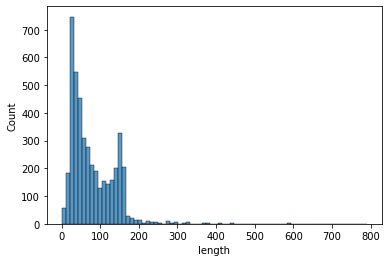

In [160]:
sns.histplot(data = X_train, x = 'length')

In [161]:
X_train.describe()

,length
count,4457.000000
mean,80.320395
std,58.645732
min,2.000000
25%,36.000000
50%,62.000000
75%,122.000000
max,790.000000


### ¿Hay alguna diferencia entre las longitudes de mensajes *ham* y *spam*?

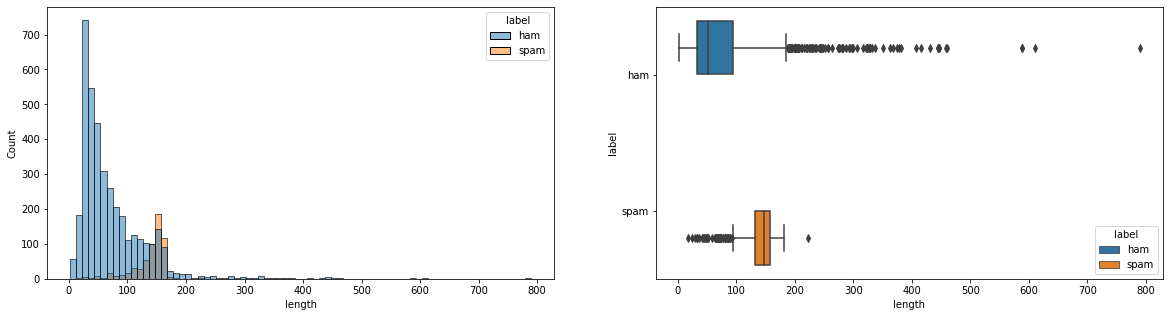

In [175]:
# Creamos el objeto dataframe temporalmente para el grafico
df = pd.concat([y_train,X_train], axis=1)
df[target] = df[target].map({0:'ham', 1:'spam'})

fig, axs = plt.subplots(ncols=2, figsize=(20,5)) # figsize: largo x ancho
sns.histplot(data = df, x = 'length', hue = 'label', ax=axs[0])
sns.boxplot(data = df, x = 'length',  y = 'label', hue='label', ax=axs[1])

del(df) # eleminamos el objeto temporal

graficamente se puede observar en el boxplot que la mediana de la longitud del mensaje de un spam es mayor a la de un ham.

la variable longitud presenta valores atipicos, pero este puede ser significativo para el modelo, dado que una extensa longitud pude dar indicios de que no es spam.

## Tratamiento de valores nulos

In [177]:
X_train.isna().sum()

message    0
length     0
dtype: int64

### No hay nulos, y si hubiese se descartarian los mensajes, pues un mensaje vacio no es spam, ni aporta al modelo.

### `Antes de tokenmizar y realizar el stemming, es recomendable realizar el balanceo de la muestra, dado que este afecta al numero de las filas y la matriz tf-idf trabaja en funcion del numero de filas y la frecuencia de las palabras, para ello debemos definir previamente el numero de filas al balancear`

### juntamos la totalidad de mensajes

In [77]:
message_total = ' '.join(messages['message'])

In [78]:
# cantidad de caracteres
len(message_total)

454061

#### Es necesario para poder tokenizar

In [15]:
# nltk.download('punkt')

In [16]:
total_tokens = word_tokenize(message_total)

In [19]:
total_tokens[:5]

['Go', 'until', 'jurong', 'point', ',']

In [23]:
freq = FreqDist(total_tokens)

In [25]:
freq

FreqDist({'.': 4901, 'to': 2159, 'I': 1975, ',': 1938, 'you': 1893, '?': 1550, '!': 1397, 'a': 1339, 'the': 1211, '...': 1146, ...})

In [28]:
freq.most_common(5)

[('.', 4901), ('to', 2159), ('I', 1975), (',', 1938), ('you', 1893)]

In [32]:
print(f'Hay { len(freq.keys()) } tokens diferentes')

Hay 11526 tokens diferentes


### Preprocesamiento

En esta sección se eliminan las palabras más comunes que no aportan mayor valor al texto de sinopsis de cada película. Para esto usamos la librería `nltk` y la funcion `stopwords`

In [34]:
# nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Usuario\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [41]:
# elegimos el idioma ingles
stopwords = nltk.corpus.stopwords.words('english')

In [36]:
stopwords[:5]

['i', 'me', 'my', 'myself', 'we']

In [42]:
# elegimos el idioma ingles
stemmer = SnowballStemmer('english')

In [44]:
tokens = tokenizar_y_stemming(message_total)

In [46]:
FreqDist(tokens).most_common(5)

[('u', 1132), ('call', 658), ('go', 455), ('get', 447), ('ur', 391)]

In [59]:
message_preprocesada = ' '.join(tokens)
message_preprocesada[:500]

'go jurong point crazi avail bugi n great world la e buffet cine got amor wat ok lar joke wif u oni free entri wkli comp win fa cup final tkts may text fa receiv entri question std txt rate c appli u dun say earli hor u c alreadi say nah think goe usf live around though freemsg hey darl week word back like fun still tb ok xxx std chgs send rcv even brother like speak treat like aid patent per request mell oru minnaminungint nurungu vettam set callertun caller press copi friend callertun winner va'

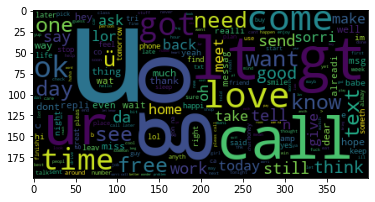

In [60]:
wordcloud = WordCloud()
wordcloud = wordcloud.generate(message_preprocesada)

plt.imshow(wordcloud)

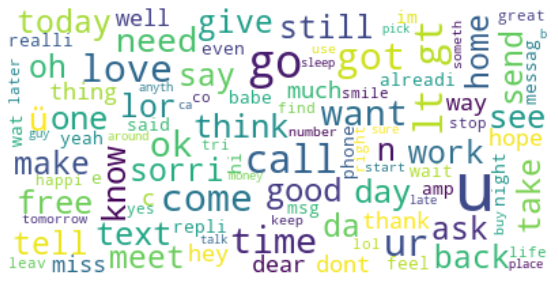

In [62]:
# maximo tamaño de fuente de una palabra, maxima cantidad de palabras y el fondo
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white")
wordcloud = wordcloud.generate(message_preprocesada)

plt.figure(figsize = (30,5)) # tamaño de figura
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off") # quitamos los ejes
plt.show()

Parámetros:

`max_df`: máxima frecuencia utilizada. si el token aparece en más del 80% del documento probablemente no tenga mucho significado

`min_df`: cantidad mínima de documentos en los que debe aparecer el token para ser considerado. En este caso 0.2 es un porcentaje de documentos pero también se puede utilizar una cantidad absoluta (5, 10 documentos)

In [109]:
tfidf_vectorizer = TfidfVectorizer(max_df = 0.8, min_df = 0.01, use_idf=True, tokenizer=tokenizar_y_stemming)

In [110]:
tfidf_matrix = tfidf_vectorizer.fit_transform(messages['message'])

In [111]:
tfidf_matrix

<5572x154 sparse matrix of type '<class 'numpy.float64'>'
	with 18826 stored elements in Compressed Sparse Row format>

In [112]:
print(tfidf_matrix.shape)

(5572, 154)


In [113]:
terms = tfidf_vectorizer.get_feature_names()

In [114]:
terms[:5]

['alreadi', 'also', 'alway', 'amp', 'anyth']

In [115]:
tfidf_matrix.shape

(5572, 154)

In [121]:
pd_text = pd.DataFrame(tfidf_matrix.toarray(), columns = terms)
pd.concat([messages['label'],pd_text], axis=1)

,label,alreadi,also,alway,amp,anyth,around,ask,award,b,...,well,win,wish,word,work,would,yeah,year,yes,ü
0,ham,0.000000,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,ham,0.000000,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,spam,0.000000,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.000000,...,0.0,0.506165,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,ham,0.387906,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,ham,0.000000,0.0,0.0,0.0,0.0,0.775,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5567,spam,0.000000,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
5568,ham,0.000000,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.590556,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.508996
5569,ham,0.000000,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
5570,ham,0.000000,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
